In [43]:
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

def get_last_nonzero_ratios(group):
    ratios = []
    
    for col in ['fw_ratio', 'lat_ratio', 'bw_ratio']:
        nonzero_values = group[group[col] != 0][col]
        if not nonzero_values.empty:
            ratios.append(nonzero_values.iloc[-1])

    return max(ratios) if ratios else 0

def load_benchmark_order(order_file_path):
    with open(order_file_path, 'r') as f:
        ordered_files = [line.strip() for line in f if line.strip()]
    return {filename: idx for idx, filename in enumerate(ordered_files)}

def get_config_label(config_string):
    parts = config_string.split(', ')
    
    fw = 'True' in parts[0]  # run_fw
    lat = 'True' in parts[1]  # run_lat  
    bw = 'True' in parts[2]  # run_bw
    
    label_parts = []
    if fw:
        label_parts.append('F')
    if lat:
        label_parts.append('L') 
    if bw:
        label_parts.append('B')
    
    if not label_parts:
        return "Config None"
    
    return f"Config {''.join(label_parts)}"

def process_sparsity_file(filepath, sparsity_level, order_file_path=None):
    df = pd.read_csv(filepath)
    
    # Load custom order if provided
    order_dict = None
    valid_files = None
    if order_file_path:
        order_dict = load_benchmark_order(order_file_path)
        valid_files = set(order_dict.keys())
    
    # Group by filename and combination of run flags
    grouped_data = []
    
    for filename in df['file_name'].unique():
        if valid_files and filename not in valid_files:
            continue
            
        file_data = df[df['file_name'] == filename]
        benchmark_id = extract_benchmark_id(filename, order_dict)
        
        # Get unique combinations of run flags
        combinations = file_data[['run_fw', 'run_lat', 'run_bw']].drop_duplicates()
        for _, combo in combinations.iterrows():
            combo_data = file_data[
                (file_data['run_fw'] == combo['run_fw']) &
                (file_data['run_lat'] == combo['run_lat']) &
                (file_data['run_bw'] == combo['run_bw'])
            ]
            
            if not combo_data.empty:
                val = get_last_nonzero_ratios(combo_data)
                config = f"run_fw={combo['run_fw']}, run_lat={combo['run_lat']}, run_bw={combo['run_bw']}"
                
                grouped_data.append({
                    'benchmark_id': benchmark_id + 1,
                    'filename': filename,
                    'config': config,
                    'val': val * 100, 
                })
    return pd.DataFrame(grouped_data)

def create_plotly_bar_plot(data, sparsity_level, indices):
    data = data.sort_values('benchmark_id')
    
    unique_benchmarks = sorted(data['benchmark_id'].unique())
    unique_configs = sorted(data['config'].unique())
    
    # Color scheme similar to your second file
    colors = ['#2ca02c', '#ff7f0e', '#d62728', '#1f77b4', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    # Create the figure
    fig = go.Figure()
    
    # Calculate bar positions
    n_configs = len(unique_configs)
    bar_width = 0.15
    
    for i, config in enumerate(unique_configs):
        config_data = data[data['config'] == config].sort_values('benchmark_id')
        
        # Get values for each benchmark
        values = []
        benchmark_labels = []
        for bench_id in unique_benchmarks:
            if bench_id not in indices:
                continue
            bench_data = config_data[config_data['benchmark_id'] == bench_id]
            if not bench_data.empty:
                values.append(bench_data['val'].iloc[0])
                benchmark_labels.append(bench_data['filename'].iloc[0])
            else:
                values.append(0)
                benchmark_labels.append(f"Benchmark {bench_id}")
        
        # Calculate x positions for this configuration
        x_offset = (i - n_configs/2 + 0.5) * bar_width
        x_positions = [x + x_offset for x in range(len(unique_benchmarks))]
        
        # Create bars
        fig.add_trace(go.Bar(
            x=x_positions,
            y=values,
            name=get_config_label(config),
            marker_color=colors[i % len(colors)],
            marker_line_width=1,
            marker_line_color='black',
            opacity=0.9,
            width=bar_width,
            hovertemplate=(
                'Benchmark: %{customdata}<br>' +
                'Config: ' + get_config_label(config) + '<br>' +
                'Ratio: %{y:.2f}%<br>' +
                '<extra></extra>'
            ),
            customdata=benchmark_labels
        ))

    # Apply professional styling similar to your second file
    fig.update_layout(
        title=dict(
            text=f"Sparsity Level: {sparsity_level}",
            x=0.5,
            xanchor='center',
            font=dict(size=14, color='#2c3e50'),
            y=0.95
        ),
        xaxis=dict(
            title="Benchmark ID",
            tickvals=list(range(len(indices))),
            ticktext=[str(i) for i in indices],
            showgrid=True,
            gridwidth=2,
            gridcolor='#f0f0f0',
            linecolor='black',
            linewidth=2,
            tickfont=dict(size=10)
        ),
        yaxis=dict(
            title="Ratio (%)",
            showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            linecolor='black',
            linewidth=1,
            tickfont=dict(size=10)
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.15,
            xanchor="center",
            x=0.5,
            font=dict(size=9),
            itemsizing='constant',
        ),
        margin=dict(t=80, b=100, l=60, r=50),
        font=dict(size=10),
        hovermode='closest',
        width=800,
        height=500
    )
    
    return fig

def create_multi_sparsity_plot(sparsity_data_dict):
    """Create subplot with multiple sparsity levels"""
    n_plots = len(sparsity_data_dict)
    
    if n_plots <= 2:
        rows, cols = 1, n_plots
        subplot_titles = list(sparsity_data_dict.keys())
    else:
        rows = 2
        cols = (n_plots + 1) // 2
        subplot_titles = list(sparsity_data_dict.keys())
    
    fig = make_subplots(
        rows=rows, cols=cols,
        subplot_titles=[f'Sparsity: {title}' for title in subplot_titles],
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )
    
    colors = ['#2ca02c', '#ff7f0e', '#d62728', '#1f77b4', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    for idx, (sparsity_level, data) in enumerate(sparsity_data_dict.items()):
        row = (idx // cols) + 1
        col = (idx % cols) + 1
        
        # Sort by benchmark_id for consistent ordering
        data = data.sort_values('benchmark_id')
        unique_benchmarks = sorted(data['benchmark_id'].unique())
        unique_configs = sorted(data['config'].unique())
        
        n_configs = len(unique_configs)
        bar_width = 0.15
        
        for i, config in enumerate(unique_configs):
            config_data = data[data['config'] == config].sort_values('benchmark_id')
            
            # Get values for each benchmark
            values = []
            benchmark_labels = []
            for bench_id in unique_benchmarks:
                bench_data = config_data[config_data['benchmark_id'] == bench_id]
                if not bench_data.empty:
                    values.append(bench_data['val'].iloc[0])
                    benchmark_labels.append(bench_data['filename'].iloc[0])
                else:
                    values.append(0)
                    benchmark_labels.append(f"Benchmark {bench_id}")
            
            # Calculate x positions for this configuration
            x_offset = (i - n_configs/2 + 0.5) * bar_width
            x_positions = [x + x_offset for x in range(len(unique_benchmarks))]
            
            # Create bars
            fig.add_trace(go.Bar(
                x=x_positions,
                y=values,
                name=get_config_label(config) if idx == 0 else get_config_label(config),  # Show legend only for first subplot
                marker_color=colors[i % len(colors)],
                marker_line_width=1,
                marker_line_color='black',
                opacity=0.9,
                width=bar_width,
                showlegend=(idx == 0),  # Only show legend for first subplot
                hovertemplate=(
                    'Benchmark: %{customdata}<br>' +
                    f'Config: {get_config_label(config)}<br>' +
                    'Ratio: %{y:.2f}%<br>' +
                    '<extra></extra>'
                ),
                customdata=benchmark_labels
            ), row=row, col=col)
        
        # Update x-axis for this subplot
        fig.update_xaxes(
            tickvals=list(range(len(unique_benchmarks))),
            ticktext=[str(bid) for bid in unique_benchmarks],
            showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            linecolor='black',
            linewidth=1,
            tickfont=dict(size=9),
            title_text="Benchmark ID" if row == rows else "",
            row=row, col=col
        )
        
        # Update y-axis for this subplot
        fig.update_yaxes(
            showgrid=True,
            gridwidth=1,
            gridcolor='#f0f0f0',
            linecolor='black',
            linewidth=1,
            tickfont=dict(size=9),
            title_text="Ratio (%)" if col == 1 else "",
            row=row, col=col
        )
    
    # Apply professional styling
    fig.update_layout(
        title=dict(
            text="Sparsity Analysis - Ratio Comparison Across Configurations",
            x=0.5,
            xanchor='center',
            font=dict(size=16, color='#2c3e50'),
            y=0.95
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.05,
            xanchor="center",
            x=0.5,
            font=dict(size=9),
            itemsizing='constant',
        ),
        margin=dict(t=100, b=120, l=60, r=50),
        font=dict(size=10),
        hovermode='closest',
        width=1000,
        height=600 if rows == 1 else 800
    )
    
    return fig

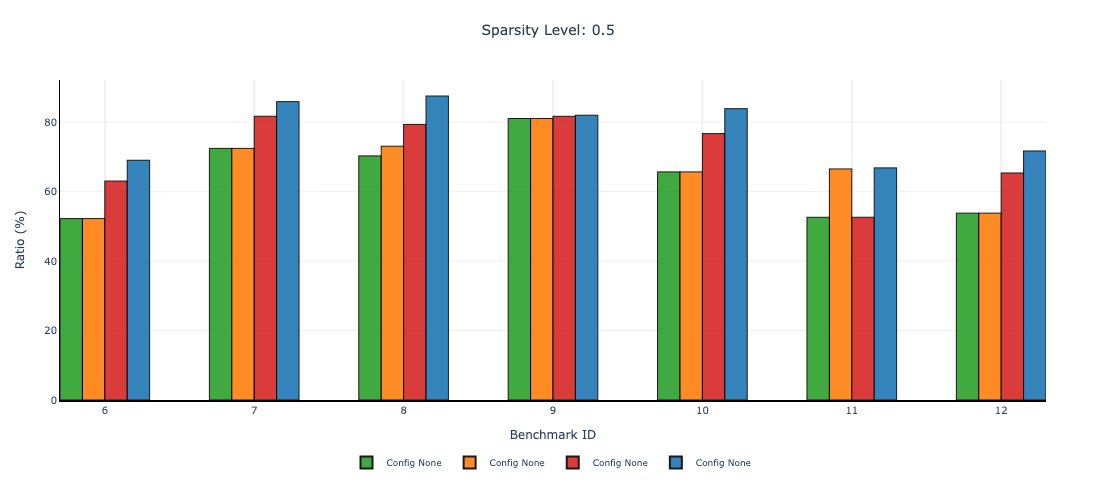

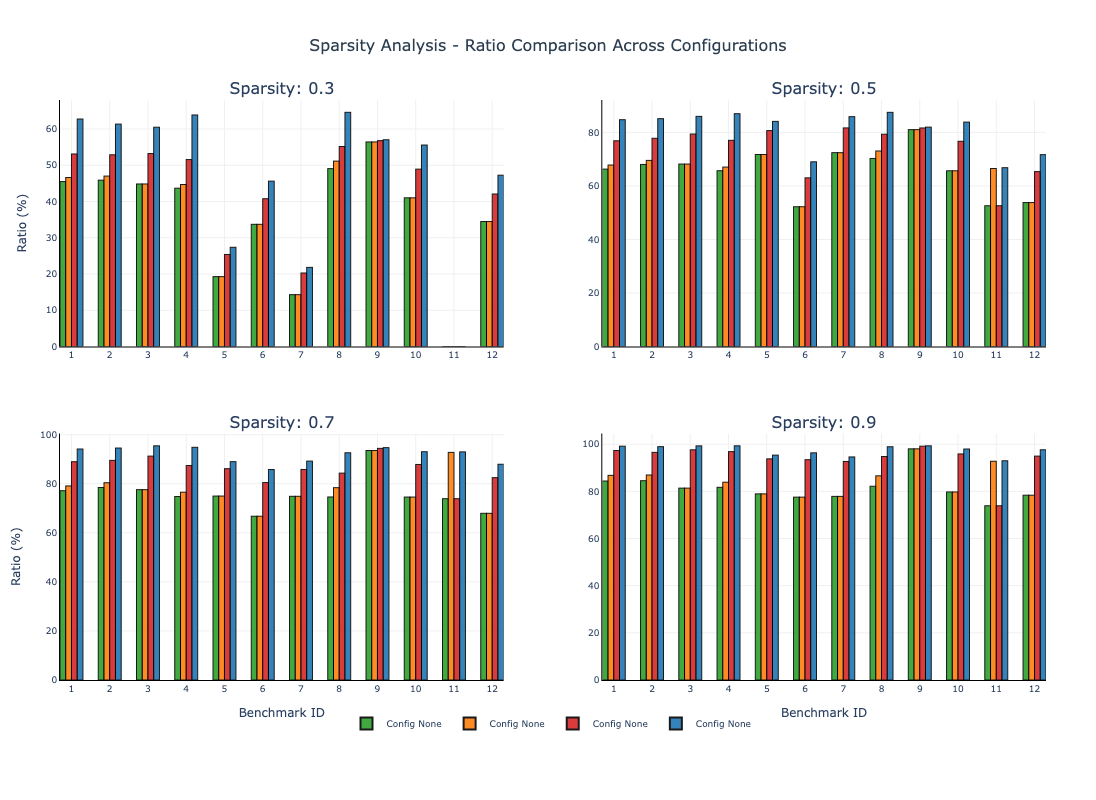

In [44]:
files = ["../analysis/einsum-data/13_0.3_prop.csv", 
         "../analysis/einsum-data/13_0.5_prop.csv", 
         "../analysis/einsum-data/13_0.7_prop.csv", 
         "../analysis/einsum-data/13_0.9_prop.csv"]

order_file = "../analysis/einsum-data/12.txt"

sparsity_data = {}
for i, (level, filepath) in enumerate(zip([0.3, 0.5, 0.7, 0.9], files)):    
    sparsity_data[level] = process_sparsity_file(filepath, level, order_file)

single_fig = create_plotly_bar_plot(sparsity_data[0.5], "0.5", range(6, 13))
single_fig.show()
multi_fig = create_multi_sparsity_plot(sparsity_data)
multi_fig.show()
